<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/L7_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

Good visual explonation: https://poloclub.github.io/cnn-explainer/

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor
from timeit import default_timer as timer
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Utils
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def print_train_time(
    start: float,
    end: float,
    device: torch.device = device):
  """ Print the difference between sthe start and the end time """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


def eval_model(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """ Return a dictionary containing the results of the model predictions """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the avarage loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__, # This only work for model created with a class
      "model_loss": loss.item(),
      "model_acc": acc
      }

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
):

  """ Perform the trining speps on the data_loader """

  # Training
  train_loss, train_acc = 0, 0
  model.train()

  # Train on batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # calculate loss / epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  if batch % 400 == 0:
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}%")


def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):

  """ Perform a testing on model with test data_loader """

  # testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y , y_pred = test_pred.argmax(dim=1)) # test_pred.argmax(dim=1) get the highest value INDEX

    # calculate accuracy and loss / test batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}% \n")

In [4]:
train_data = datasets.FashionMNIST(
  root="data", # where to download it
  train=True, # do we want the training data set
  transform=ToTensor(), # transform it
  download=True, # download or not?
  target_transform=None # keep the labels as it is
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  transform=ToTensor(),
  download=True,
  target_transform=None # keep the labels as it is
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.46MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
# class names AKA the labels
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# map the classes to labels
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# Set up hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 0.1
RANDOM_SEED = 42
INPUT_SHAPE = (1, 28, 28)
OUTPUT_SHAPE = len(class_names) # dynamicly assigne to the class names
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.2

In [8]:
## Prepare DataLoder

train_dataloader = torch.utils.data.DataLoader(
  dataset=train_data,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=1,
  pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_data,
  batch_size=BATCH_SIZE,
  shuffle=False, # keep it in order, better for testing
  num_workers=1,
  pin_memory=True
)

print(len(train_dataloader) / BATCH_SIZE)
#type(train_dataloader)

58.59375


In [9]:
# make model
class CNN_1(nn.Module):
  def __init__(self, input_shape:int, output_shape:int, hidden_units:int, dropout_rate:float):
    super().__init__()

    # feature learning block 1
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # feature learning block 2
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Calculate the output shape dynamically
    # Create a dummy input with the correct shape
    dummy_input = torch.randn(1, *INPUT_SHAPE) # INPUT_SHAPE is a global variable
                                                # (1, 28, 28)
    # Pass the dummy input through the convolutional blocks
    output_shape_conv = self.conv_block_2(self.conv_block_1(dummy_input)).shape
    # Flatten the output shape and get the number of features
    num_features = output_shape_conv[1] * output_shape_conv[2] * output_shape_conv[3]

    # classification block
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=num_features, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [10]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_1 = CNN_1(
  input_shape=INPUT_SHAPE[0], # the Tiny VGG taake in color chanesl first, it THIS case we use 1 as we use black and white images ant the color chanel is only 1 insted of 3 (RGB)
  output_shape=OUTPUT_SHAPE,
  hidden_units=HIDDEN_UNITS,
  dropout_rate=DROPOUT_RATE # not in us atm
).to(device)

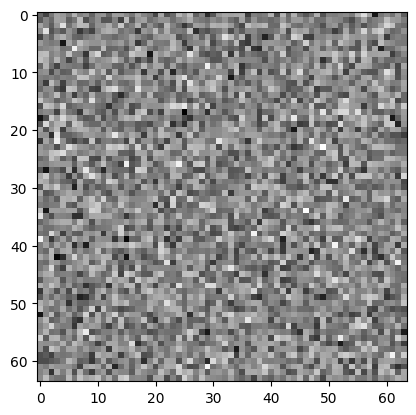

In [18]:
# Stepping through `nn.Conv2d()`

# create a batch of "images" .. aka data that look like the image tensor
X_batch = torch.randn(size=(32, 3, 64, 64)).to(device) # (batch_size, color_channels, height, width)
test_image = X_batch[0][0]
plt.imshow(test_image.squeeze().to('cpu'), cmap="binary")

torch.Size([10, 62, 62])


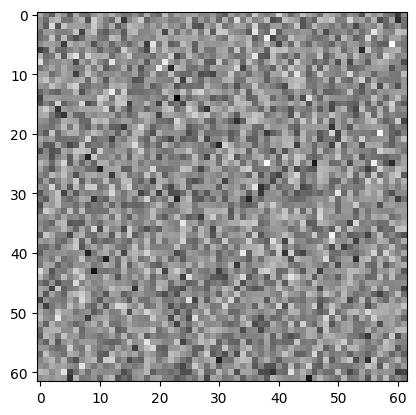

In [20]:
test_2d = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0).to(device)
test_2d_output = test_2d(X_batch[0])
print(test_2d_output.shape)
plt.imshow(test_2d_output[0].detach().squeeze().to('cpu'), cmap="binary")

torch.Size([10, 31, 31])


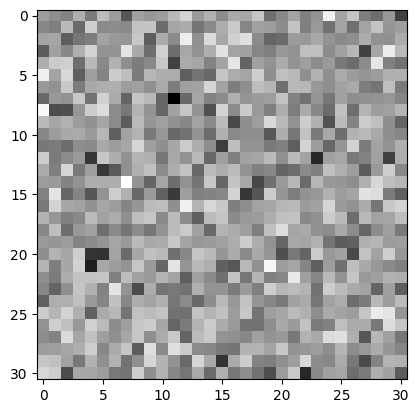

In [21]:
# Create a sample of max poul layer
test_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
test_maxpool_output = test_maxpool(test_2d_output)
print(test_maxpool_output.shape)
plt.imshow(test_maxpool_output[0].detach().squeeze().to('cpu'), cmap="binary")

Set up loss and optimizer

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

In [16]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# start timer
start_time = timer()

# build train and test loop
for epoch in tqdm(range(NUM_EPOCHS)):
  print(f"Epoch: {epoch}")
  train_step(
    model=model_1,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    device=device
  )
  test_step(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
  )

# end timer
end_time = timer()

# print the train time
print_train_time(start_time, end_time, device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Test loss: 0.3734 | Test acc: 86.6114% 

Epoch: 1
Test loss: 0.3033 | Test acc: 89.0475% 

Epoch: 2
Test loss: 0.2859 | Test acc: 89.5867% 

Train time on cuda: 52.613 seconds


52.612576802000035

In [17]:
# get model results
model_1_results = eval_model(
  model=model_1,
  data_loader=test_dataloader,
  loss_fn=loss_fn,
  accuracy_fn=accuracy_fn
)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CNN_1',
 'model_loss': 0.28586146235466003,
 'model_acc': 89.58666134185303}

In [23]:
# Compare model results and training time
import pandas as pd

model_1_results_df = pd.DataFrame([model_1_results])
model_1_results_df

,model_name,model_loss,model_acc
0,CNN_1,0.285861,89.586661


In [24]:
# Add training time to results comparison
model_1_results_df["train_time_sec"] = print_train_time(start_time, end_time, device=device)
model_1_results_df

Train time on cuda: 52.613 seconds


,model_name,model_loss,model_acc,train_time_sec
0,CNN_1,0.285861,89.586661,52.612577


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

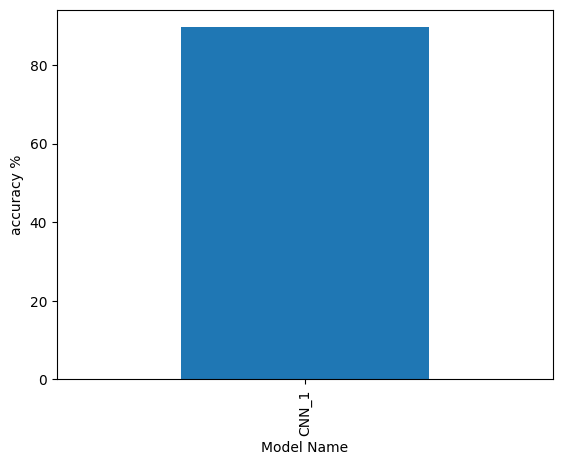

In [26]:
# Visualize the model results
model_1_results_df.set_index("model_name")["model_acc"].plot.bar()
plt.ylabel("accuracy %")
plt.xlabel("Model Name")
plt

In [36]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [49]:
# Make and evaluate

def make_predictions(
  model: torch.nn.Module,
  data: list,
  device: torch.device = device
):
  """ Make predictions on the data_loader """

  perd_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in tqdm(data):
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred = model(sample)
      pred_lob = torch.softmax(pred.squeeze(), dim=0)
      perd_probs.append(pred_lob.detach().cpu().numpy())

  #perd_probs = torch.stack(perd_probs)
  return perd_probs

import random
import numpy as np
# random seed
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(
    model=model_1,
    data=test_samples,
    device=device
    )

print(pred_probs[:2])

# Get the highest
pred_labels = torch.argmax(torch.Tensor(pred_probs), dim=1)
pred_labels

  0%|          | 0/9 [00:00<?, ?it/s]

[array([2.2900419e-06, 7.6319117e-07, 1.1838802e-06, 9.3023287e-09,
       3.2463614e-08, 9.9997234e-01, 3.6076344e-06, 1.4490097e-07,
       3.2792141e-06, 1.6348868e-05], dtype=float32), array([2.32087187e-02, 9.32796061e-01, 3.12188349e-05, 1.48840342e-02,
       7.70516973e-03, 1.13574155e-04, 2.05712598e-02, 6.18155973e-05,
       6.17863960e-04, 1.02522608e-05], dtype=float32)]


<ipython-input-49-4b01486b65a1>:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  pred_labels = torch.argmax(torch.Tensor(pred_probs), dim=1)


tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

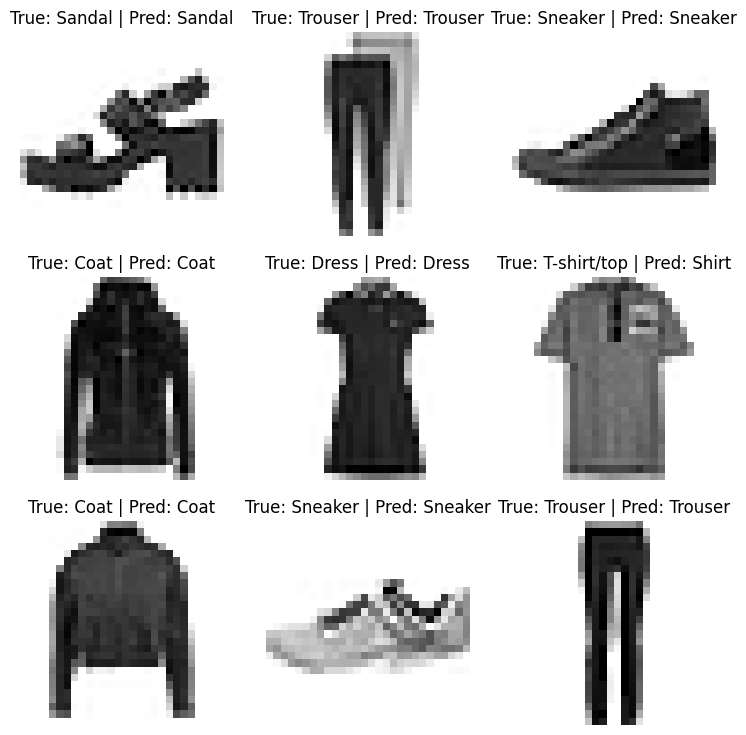

In [58]:
from types import prepare_class
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze().to('cpu'), cmap="binary")

  # find the pred lable's
  # Get the index of the highest probability for the current sample
  pred_label_index = np.argmax(pred_probs[i])
  # Use this index to get the predicted label from class_names
  pred_label = class_names[pred_label_index]
  true_label = class_names[test_labels[i]]

  plt.title(f"True: {true_label} | Pred: {pred_label}")
  plt.axis("off")

# Save and load the model

In [61]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CNN_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

torch.save(model_1.state_dict(), MODEL_SAVE_PATH)

In [62]:
# Load and make new instance

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_1_loaded = CNN_1(
  input_shape=INPUT_SHAPE[0],
  output_shape=OUTPUT_SHAPE,
  hidden_units=HIDDEN_UNITS,
  dropout_rate=DROPOUT_RATE
).to(device)

model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-62-0ff09fb70504>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [63]:
# Evaluate loaded model

model_1_loaded_results = eval_model(
  model=model_1_loaded,
  data_loader=test_dataloader,
  loss_fn=loss_fn,
  accuracy_fn=accuracy_fn
)

model_1_loaded_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CNN_1',
 'model_loss': 0.28586146235466003,
 'model_acc': 89.58666134185303}